# A Stommel 2-Box Model for the Atlantic Meridional Overturning Circulation

### *Or, Addressing a Paleoclimate Puzzle with Bifurcation Theory*

In this notebook we investigate a simple dynamical system modelling of the north Atlantic's **thermohaline circulation** originating in a 1961 paper of Hank Stommel. This model treats the equatorial Atlantic and polar Atlantic as two connected "boxes" through which heat and salt can flow. By numerically determining of the model's bifurcation diagram, we'll see that either temperature *or* salinity gradients can dominate the inter-box flow, and that the direction of this flow can change as a function of a bifurcation parameter.

The bifurcation theory of Stommel-type models has been used as "step zero" of an explanation for the **Dansgard-Oeschger (DO) events**, certain rapid transitions observed in paleoclimate time series data. We'll briefly touch on the connections between DO events and THC modelling as well. 

### Sources/Recommended Reading
- *Nonlinear Climate Dynamics*, H. Dijkstra. Cambridge, 2013. 
- *Mathematical Geoscience*, A. Fowler. Springer, 2011.
- "GRIP Ice Core 248KYr Oxygen Isotope Data", S. Johnsen et al. Available online at https://www.ncei.noaa.gov/access/paleo-search/study/17839, accessed Feb. 7, 2025.
- *Atmosphere, Ocean, and Climate Dynamics: An Introductory Text*, J. Marshall and R. A. Plumb. Academic Press, 2008.
- "Thermohaline Convection with Two Stable Regimes of Flow", H. Stommel. *Tellus* XIII (1961), 2, pp.224-230.
- *Climate and the Oceans*, G. Vallis. Princeton, 2011. 

Let's start off by importing packages, setting some plot parameters, and defining helper functions. 

In [1]:
import joblib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy 

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# set up nice fonts for plotting 
plt.rc('font', family='serif')
try:
    usetex = True
    plt.rc('text', usetex=usetex)
except RuntimeError:  # catch an error if the user doesn't have tex installed
    usetex = False

# set up plot size and other params
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = 'k'

In [2]:
def plot_time_series(t, y, ax, linewidth=2, color='xkcd:jade', linestyle="solid", label=None):
    ax.plot(t,y, linewidth=linewidth, color=color, linestyle=linestyle, label=label)

    plt.xlim([0.999*np.amin(t),1.001*np.amax(t)])

    if usetex:
        plt.xlabel(r"$t$", fontsize=20, color = 'k')
    else: 
        plt.xlabel(r"t", fontsize=20, color = 'k')

    plt.tick_params(axis='x', which='both', top='off', color = 'k')
    plt.xticks(fontsize=16, rotation=0, color = 'k')
    plt.tick_params(axis='y', which='both', right='off', color = 'k')
    plt.yticks(fontsize=16, rotation=0, color = 'k')

    plt.tight_layout()

## The Thermohaline Circulation & Paleoclimate

The **thermohaline circulation (THC)** or **meriodional overturning circulation (MOC)** of the north Atlantic ocean refers to a stable meriodional (that is, north-south/longitudinal) flow pattern driven by density differences between polar and equatorial water. Since the density of ocean water is known to vary directly with temperature and salinity, and "haline" is a fancy way of saying "salty", the name "thermohaline" is definitely appropriate in describing this flow.  In the modern-day ocean, the THC transports warm equatorial surface water poleward, where it cools, sinks, and displaces deep, salty, cold water. The northern deep water then flows equatorward, eventually rising to the surface thanks to turbulent heat transfer; see Vallis for some nice, plain-English discussion. The whole discussion is additionally complicated by salinity forcing both at the equator (salinity increases due to evaporation, and decreases due to precipitation) and at the pole (salinity decreases due to the melting of Arctic ice). Clearly, the THC plays a key role in global heat transfer and therefore global climate. For instance, if it were to cease or reverse direction, north-western Europe could expect to have a much colder climate: westerly winds would not be heated when passing over warm equatorial surface water that has been transported poleward. For more on the physics of the thermohaline circulation, see Marshall & Plumb ch. 11 and Vallis. 

Owing to the climatic significance of the THC, disruption of this circulation has been posited as an explanation for sudden temperature changes observed in paleoclimate data. Let's look at some examples of these rapid temperature changes using Pandas. You may visit https://www.ncei.noaa.gov/access/paleo-search/study/17839 and download data from the Greenland Ice Core Project (GRIP). This data reports time series measurements of a **proxy** for global temperature, specifically the normalized ratio of the isotope oxygen-18 to the lighter oxygen-16, denoted $\delta^{18}$O. For our purposes, all we need to know is that a relative large $\delta^{18}$O implies a larger temperature; see Dijkstra ch.10. 

The code below assumes you've stored the $\texttt{.txt}$ file containing the data in a directory called $\texttt{data}$ contained the same directory where this notebook is: if you change the location of the data file, please change the path in the next code box as well. As is good Pandas practice, we plot the head of the dataframe holding our data to quickly see everything the file has to offer. 

In [3]:
path = "data/gripd18o-noaa.txt"
df = pd.read_csv(path, sep='\t', header=148)
df.head()

,depth_top_m,d18O_smow,age_top_calBP
0,0.00,-35.04,-39.000
1,0.55,-33.81,-38.065
2,1.10,-36.18,-37.187
3,1.65,-34.92,-36.118
4,2.20,-35.62,-35.145


Following section 2.5 of Fowler's book, let's plot a slice of this data from about 30ka (30,000 years) ago to 90ka. 

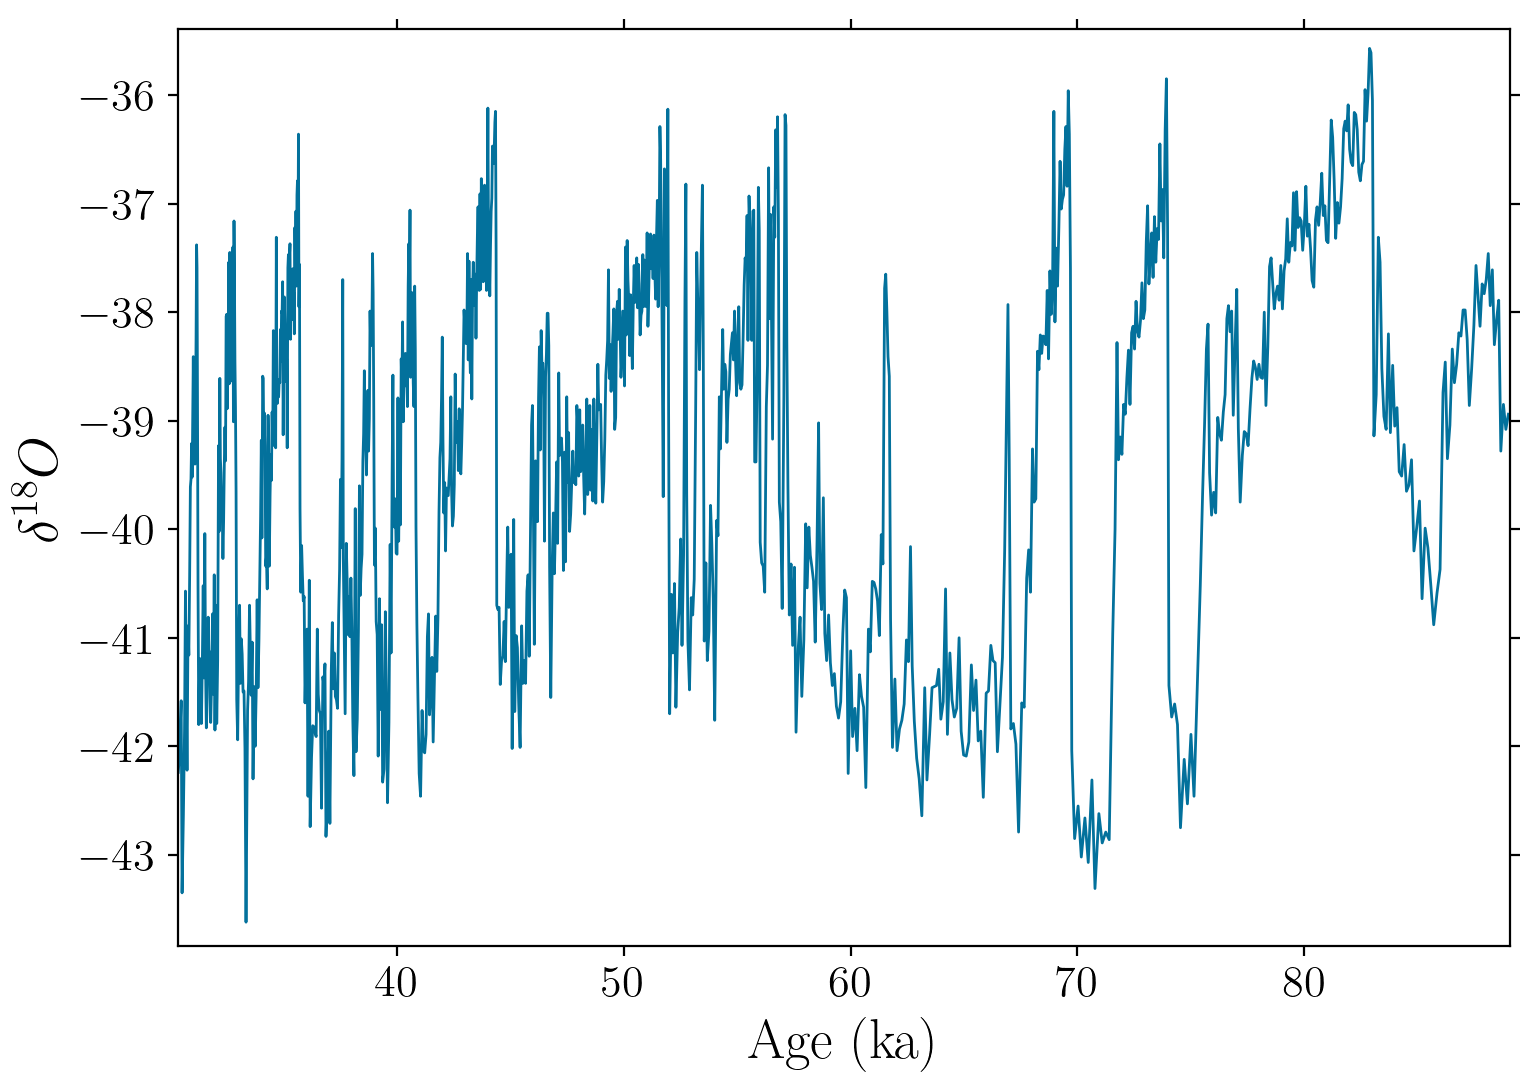

In [4]:
age_ka = df["age_top_calBP"][-1600:-550]/1e3
isotope_ratio = df["d18O_smow"][-1600:-550]

fig, ax = plt.subplots()
plot_time_series(age_ka, isotope_ratio, ax, linewidth=1, color="xkcd:ocean blue")
plt.ylim([1.005*np.amin(isotope_ratio),0.995*np.amax(isotope_ratio)])
plt.xlabel("Age (ka)", fontsize="20")
if usetex:
    plt.ylabel("$\delta^{18}O$", fontsize="20")
else: 
    plt.ylabel(r"δ18 O", fontsize=20, color = 'k')
fig.set_size_inches(8, 6)  
plt.show()

The frequent dramatic temperature spikes, accompanied by even faster temperature drops, are immediately striking. These rapid changes are the **Dansgaard-Oeschger (DO) events**. Even though DO events are high-frequency features, their near-regularity suggests they are not due to noise and may have a mechanistic cause! For instance, Fowler describes a plausible situation where DO events are triggered by periodic glacial melts that rapidly force the THC with an injection of fresh water, causing a temporary shutdown or reversal of the equatorial-polar density gradient and in turn global temperature alterations.

So, here is the big question: should we expect there to be a permanent, preferred stable direction for the THC for a wide variety of climatic paramters, or can its direction change in response to parameter adjustment? If the answer is "yes" then Fowler's explanation of DO events starts to sound pretty good, and suggests that the ocean circulation is important in DO event phenomenology. If the answer is "no", however, then it's more reasonable to conclude that the THC played a small role in the rapid climate change of the DO events. 

## The 2-Box Model

Below, we address the "big question" using a toy model. Since we know that the THC is driven by temperature and salinity gradients, can a model *only* including these state variables allow for THC shutdown and/or reversal? This line of thinking goes back to Stommel in 1961. 

We work with a zero-dimensional (purely time-dependent) model where the polar Atlantic ocean and equatorial Atlantic ocean are divided into two well-mixed boxes of salty water. Fresh water leaves the equatorial box owing to evaporation (note how tropical precipitation is ignored here!), and is injected into the polar box owing to glacial melt. The boxes are connected in such a way that water can flow freely in between them while conserving mass. The inter-box flux is defined by

$$
q = k\left(\rho_{e} - \rho_{p}\right)
$$

where $\rho_{e}, \rho_{p}$ are the equatorial and polar water densities respectively, and $k>0$ is a proportionality constant. If $q<0$ then polar water is heavier than equatorial water and we're in a situation like the modern-day ocean described earlier. If $q>0$ then equatorial water is heavier, and the flow direction reverses relative to the modern ocean. Finally, $q=0$ corresponds to a THC shutdown.

Section 2.5 of Fowler contains a detailed derivation of the model equations under the assumptions outlined above, in addition to assuming the simplest possible fluxes for heat and salt. After some state-space transformations and nondimensionalization, the state vector of the model can be written as $x=(s,\theta)^{\mathrm{T}}$ where $s$ is the salinity gradient and $\theta$ is the temperature gradient. These are defined in such a way that $s>0$ corresponds to an equatorial box that is saltier than the polar one, and vice versa: the same goes for temperature. 

Using the notation from Fowler's book (with dimensionless parameters $\epsilon, \mu,k,R$), the nondimensional model reads

$$
\dot{s} = 1 - s\left(\epsilon + |q(x)|\right)
$$

$$
\dot{\theta} = 1 - \theta\left(\mu + |q(x)|\right)
$$

$$
q(x) = k\left(Rs-\theta\right).
$$

I remark that this equations are fun from a mathematical perspective: it's not often that you find non-pathological dynamical systems with continuous-but-non-differentiable right-hand sides! Of course, the absolute value function is Lipschitz, so the lack of differentiability of the right-hand side with respect to the state variables is not an obstruction to the existence and uniqueness of the flow for these dynamics.  

For convenience, we define the right-hand side of the ODE system by 

$$
f(x) = \begin{pmatrix} 1 - s\left(\epsilon + |q(x)|\right) \\ 1 - \theta\left(\mu + |q(x)|\right) \end{pmatrix}. 
$$

Let's put these functions into the computer: 

In [5]:
def q(x, **params):
    """Flow rate for state x at certain parameter values."""
    return params["k"]*(params["R"]*x[0]-x[1])
    
def f(x, **params):
    """Right-hand side of the governing ODE system (involving some parameters)"""
    return np.array([1.-x[0]*(params["epsilon"]+np.abs(q(x,**params))), 1.-x[1]*(params["mu"]+np.abs(q(x,**params)))])

We'll use the parameter estimates from Fowler's book, although I don't like using any parameters without knowing their uncertainties! So if you have more robust estimates with confidence intervals, please let me know :) . 

In [6]:
params = {
    "k": 1,
    "R": 0.5,
    "epsilon": 3e-3,
    "mu": 5e-3,
}

In the sequel, we typically fix $k,\epsilon,\mu$ and vary $R$. We think of $R$ as the relative importance of salinity in determining the flow direction $q$: if $R$ is small then temperature gradients drive the engine, and if $R$ is large then salinity gradients do the work.  

Before doing any numerical work, we immediately see that THC shutdown *is possible* with this model. If $R=R_{\mathrm{stop}} = \frac{\epsilon}{\mu}$ then we have an equilibrium solution 

$$
\left(s_0, \theta_0\right)^{\mathrm{T}} = \left(\frac{1}{\epsilon}, \frac{1}{\mu}\right)^{\mathrm{T}}.
$$

So, already we have a small win for the role of the THC in governing paleoclimate change! If we can show this shutdown equilibrium is unstable, this would be even better, as it would agree with the up-and-down $\delta^{18}O$ motion of the DO events (a stable shutdown would, in principle, probably show up as a relative flat warm or cold period on the time series). Note that, for Fowler's parameter values, $R_{\mathrm{stop}} = 0.6$. 

Before going further, we write some more plotting helper functions specific to this model.  

In [7]:
def plot_state(t, x):
    fig, ax = plt.subplots()
    
    if usetex:
        s_label = r"$s(t)$"
        theta_label = r"$\theta(t)$"
    else: 
        s_label = r"s(t)"
        theta_label = r"θ(t)"
        
    plot_time_series(t,x[0, :], ax, linewidth=2, color='xkcd:dark aqua', linestyle="dotted", label=s_label)
    plot_time_series(t,x[1, :], ax, linewidth=2, color='xkcd:deep red', linestyle="solid", label=theta_label)
    ax.legend(loc="best", fontsize=16)
    plt.show()

def plot_q(t,x):
    fig, ax = plt.subplots()
    plot_time_series(t,q(x, **params), ax, linewidth=2, color='xkcd:jade', linestyle="solid")
    if usetex:
        plt.ylabel(r"$q(x(t))$", fontsize=20, color = 'k')
    else: 
        plt.ylabel(r"q(x(t))", fontsize=20, color = 'k')
    plt.show()

Next, we play with some simulations of the model to get a feeling for what its dynamics look like. We start by seeing how well Euler does. 

## Solution Method 1: Vanilla Euler

In [8]:
T = 25. 
dt = .5e-1
x0 = np.array([0.8,0.2])

In [9]:
def simulate_euler(x0, T, dt, params=params, show_plot=True):
    N = 1 + int(T/dt) # num timesteps we store

    x = np.zeros((2,N), dtype=float) # init storage for state
    x[:, 0] = x0
    
    for n in range(1,N):
        x[:, n] = x[:, n-1] + dt*f(x[:, n-1], **params) 

    if show_plot:
        plot_state(np.linspace(0,T,N, endpoint=True), x)
        plot_q(np.linspace(0,T,N, endpoint=True), x)

    return {"x": x, "q": q(x, **params)}

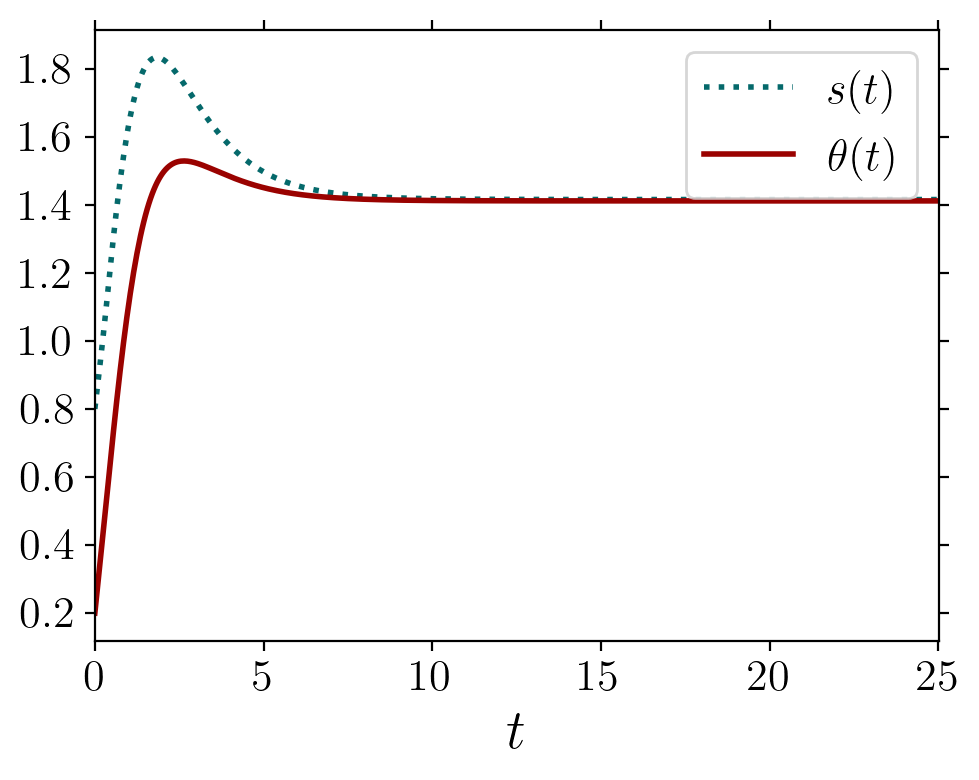

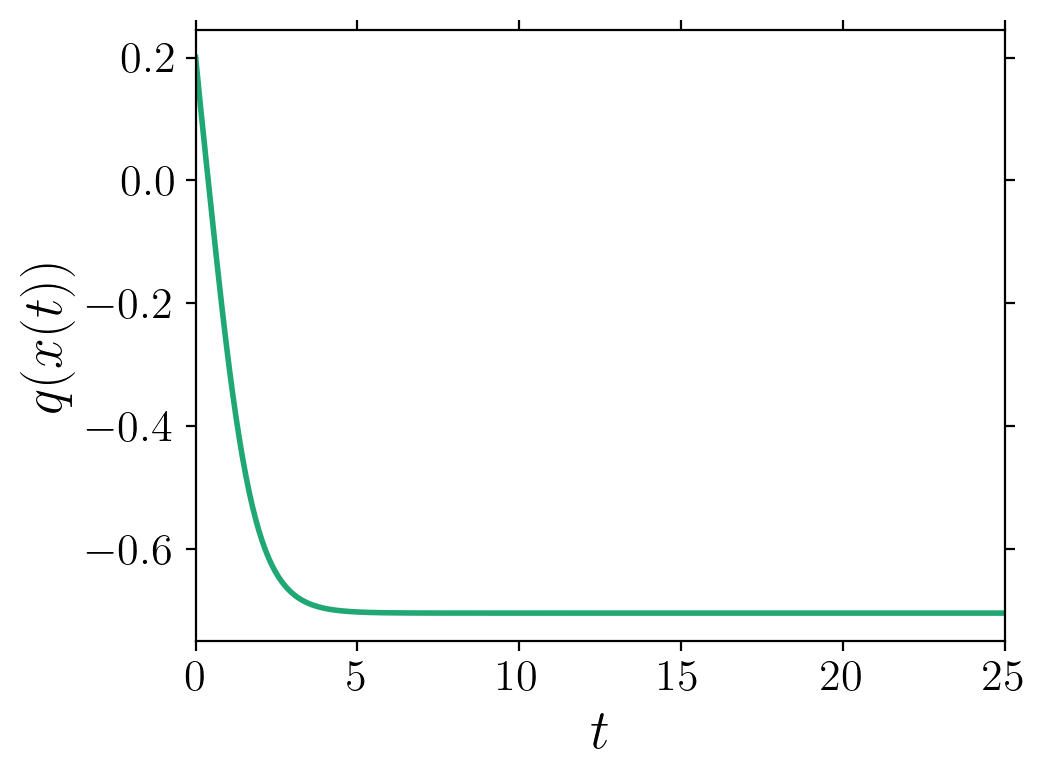

In [10]:
sim_results_euler = simulate_euler(x0, T, dt)

We see a rapid relaxation to equilibrium, which Euler's method typically does a great job at capturing (Euler has the desirable feature of capturing equilibria to machine precision, which seemingly-smart-but-actually-not schemes like the integrating factor method do not possess!). 

## Solution Method 2: SciPy RK45 

Since we'll need long-time simulations for drawing stable parts of the model's bifurcation diagram, however, a time-adaptive scheme is probably a better use of our computing resources even though Euler's accuracy is good. 

In [11]:
def simulate_rk(x0, T, params=params, show_plot=True):
    out = scipy.integrate.solve_ivp(lambda t,x: f(x, **params), (0,T), x0, method='RK45', max_step = 1.)
    t_rk = out["t"]
    x_rk = out["y"]

    if show_plot:
        plot_state(t_rk, x_rk)
        plot_q(t_rk, x_rk)

    return {"t": t_rk, "x": x_rk, "q": q(x_rk, **params)}

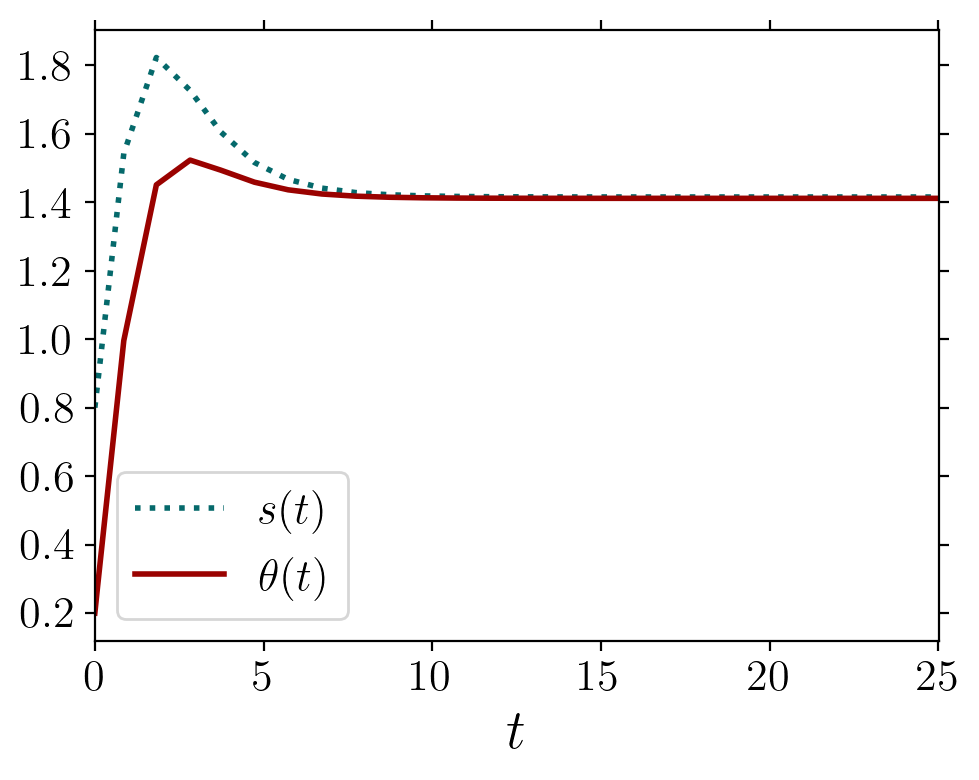

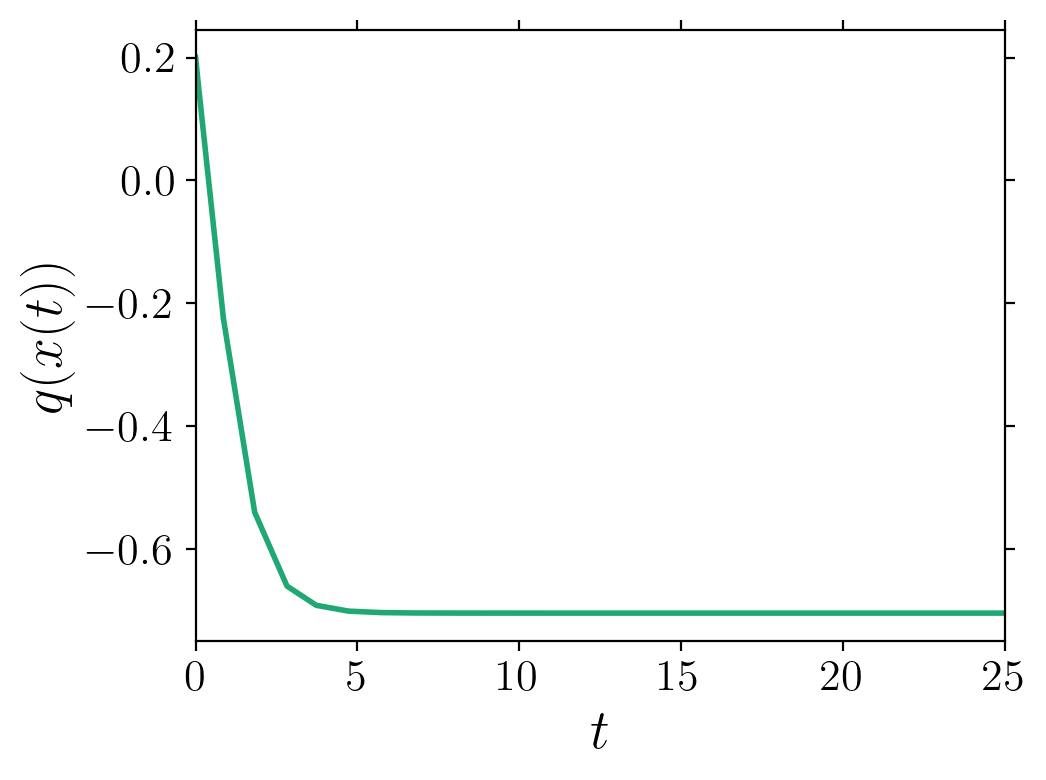

In [12]:
sim_results_rk = simulate_rk(x0, T)

Note that this adaptive method requires less than half of the time steps that Euler does: 

In [13]:
np.size(sim_results_rk["t"])

28

## Numerically Determining Equilibria

Since $f(x)$ is continuous but not differentiable, naively plugging this function into a Newton-type algorithm is not a good idea: the Jacobian estimates are destined to blow up! However, a bit of algebra shows that (provided $\mu,\epsilon\geq 0$) $f(x)=0$ if and only if we have 

$$
g(x) = \begin{pmatrix} (1-\epsilon s)^2 - s^2 q(x)^2 \\ (1-\mu \theta)^2 -\theta^2 q(x)^2 \end{pmatrix} = \begin{pmatrix} (1-\epsilon s)^2 - k^2s^2(Rs-\theta)^2 \\ (1-\mu \theta)^2 -k^2\theta^2(Rs-\theta)^2  \end{pmatrix} = 0.
$$

This is a system of two *quartic polynomial equations*, and can easily be handled using Newton-type methods. 

In [14]:
def g(x, **params):
    """The roots of this function give all equilibria for given parameter values"""
    q_sq = q(x, **params)**2
    out1 = (1.-params["epsilon"]*x[0])**2 - q_sq*x[0]**2
    out2 = (1.-params["mu"]*x[1])**2 - q_sq*x[1]**2
    return np.array([out1, out2])

In [15]:
x = scipy.optimize.fsolve(lambda x: g(x, **params), x0=np.random.rand(2), xtol=1e-12)
print(x)
print(g(x, **params))
print(q(x, **params))

[1.41520824 1.41121391]
[2.22044605e-16 2.22044605e-16]
-0.7036097944122975


Through experimenting with the code block above, we find that there is a stable equilibrium at $x\approx \left(1.415, 1.411\right)^{\mathrm{T}}$ with $q\approx -0.704$ given Fowler's default parameter values. 

## Phase Portrait

Equilibria and their stability can likewise we determined with a phase portrait. 

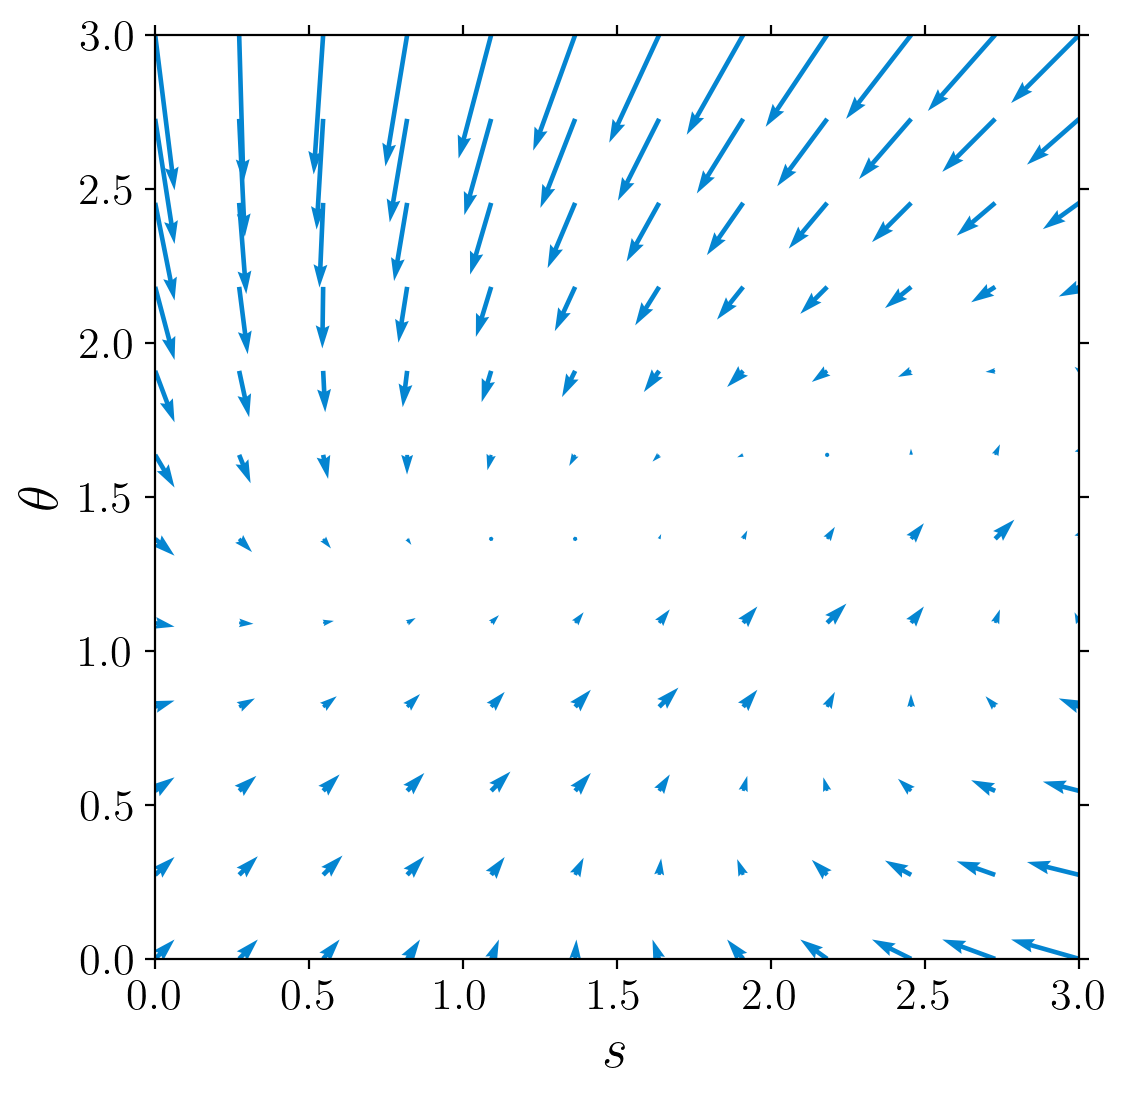

In [16]:
# Allowing you to redefine this here to quickly change the parameters if desired. 
# params = {
#     "k": 1,
#     "R": 0.97,
#     "epsilon": 3e-3,
#     "mu": 5e-3,
# }

xmax = 3. 
ymax = 3.
samples_per_axis = 12 # number of sample points per axis

# create mesh grid of data points where we sample direction field/RHS of ODE
x,y = np.meshgrid(np.linspace(0,xmax,samples_per_axis),np.linspace(0,ymax,samples_per_axis))
u, v = f([x,y], **params)

fig, ax = plt.subplots()

# define all plot parameters + ensure axis labels all look nice. 
# Lots of this stuff is purely optional. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

textcolor = 'k'

plt.xlim([0, xmax])
plt.ylim([0, ymax])

if usetex:
    plt.xlabel(r"$s$", fontsize=20, color = textcolor)
    plt.ylabel(r"$\theta$", fontsize=20, color = textcolor)
else: 
    plt.xlabel(r"s", fontsize=20, color = textcolor)
    plt.ylabel(r"θ", fontsize=20, color = textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=16, rotation=0, color = textcolor)
plt.tick_params(axis='y', which='both', right='off', color = textcolor)
plt.yticks(fontsize=16, rotation=0, color = textcolor)

# sketch arrows of ODE's direction field. 
plt.quiver(x,y,u,v, color='xkcd:cerulean', linewidth=4)

fig.set_size_inches(8, 6)  

# adjust figure aspect ratio and size for maximum clarity
ax.set_aspect(1.)

# finally, show the plot
plt.show()

With all these numerical evidence, we can safely conclude that for the default parameter values there is a single stable equilibrium corresponding to a THC with poleward flux ($q<0$) like the modern ocean. 

## Bifurcation Diagram 

Now, we start to vary the "salinity strength" parameter $R$ and see how the equilibrium flow changes. Again, the whole point of this is to see if our simple heat-salt engine model can capture THC reversal and therefore paleoclimate change. 

We'll draw a bifurcation diagram where the equilibrium $q$-values are plotted against $R$. First, we can use an ensemble of simulations to determine the *stable* equilibria. We pick a bunch of random initial conditions ($\sim \mathrm{Unif}(0,20)$) and, for every value of $R$, run a model simulation up to time $T\gg 1$ starting from each initial condition. The "tails" of each simulation trajectory (that is, the state values over the last few time steps) will lie on the model's stable attractor, so by plotting the tails of $q$ against $R$ we can see if $R$ has an effect on the direction of the equilibrium THC flow. 

Since we want to test a lot of $R$-values and a lot of initial conditions, it makes good sense to perform simulations in parallel. Right now the extent of my parallel computation knowledge is the excellent joblib package, so that's what we'll use to speed up our computations (but still, be prepared to wait a minute or so). 

In [17]:
R_samplesize = 199 # number of parameter values we want to try
x0_samplesize = 60 # number of initial conditions in out ensemble
T = int(2e3) # length of simulation in each sample
tail_size = 20 # size of the "tail" of the simulation we look at to identify the attractor
    
# create array of params and initial conditions to try
R_samples = np.linspace(0., 2., num = R_samplesize, endpoint=True)
x0_samples = np.random.uniform(0, 20, (2, x0_samplesize))

bifurcation_grid = np.zeros((x0_samplesize, R_samplesize), dtype=object)
for i in range(x0_samplesize):
    for j in range(R_samplesize):
        bifurcation_grid[i,j] =[x0_samples[:, i], R_samples[j]]

def get_tail(R, x0):
    params["R"] = R
    out = simulate_rk(x0, T, params=params, show_plot=False)
    tail = out["q"][-tail_size:]
    return tail
    
tails = joblib.Parallel(n_jobs=-1)(joblib.delayed(get_tail)(R, x0) for x0, R in np.ravel(bifurcation_grid)) 
tails = np.array(tails).T

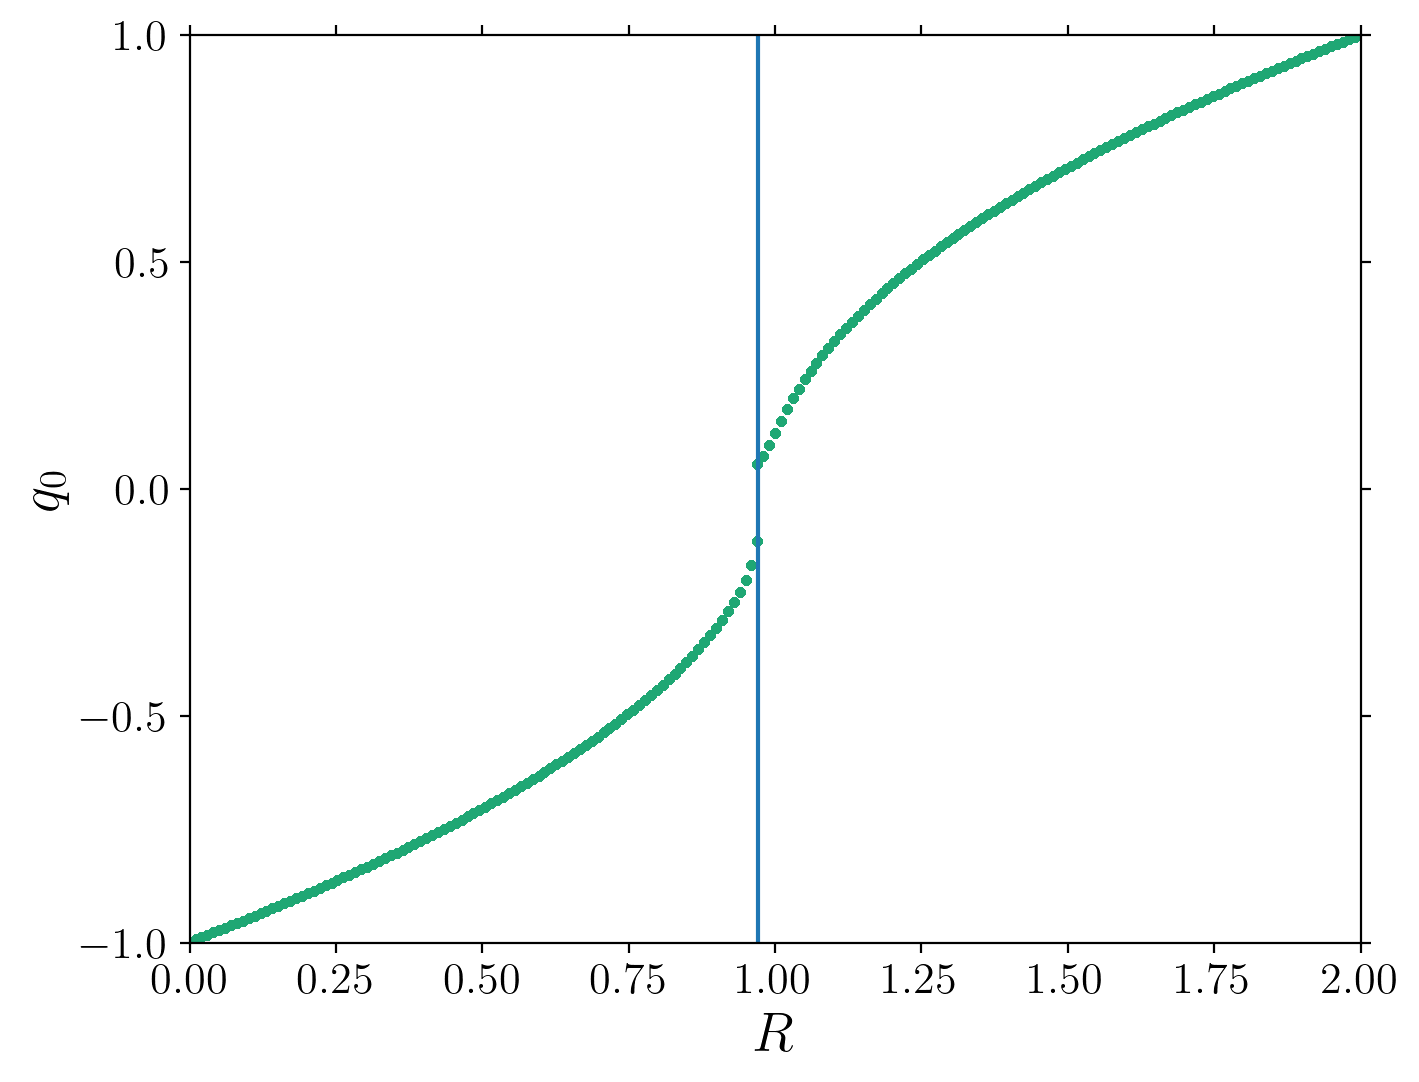

In [23]:
fig, ax =plt.subplots() 

plt.scatter(np.ravel(np.tile(R_samples, tail_size*x0_samplesize)),np.ravel(tails), s=6, color='xkcd:jade')
plt.vlines(0.97, -1, 1)

if usetex:
    plt.xlabel(r"$R$", fontsize=20, color = 'k')
    plt.ylabel(r"$q_{0}$", fontsize=20, color='k')
else: 
    plt.xlabel(r"R", fontsize=20, color = 'k')
    plt.ylabel(r"q_{0}", fontsize=20, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=8)

plt.xlim([0.,2.])
plt.ylim([-1.,1.])

plt.frameon = True 

plt.tight_layout()

fig.set_size_inches(8, 6)  

plt.show()

There is evidently a bifurcation where the equilibrium flow direction changes around $R\approx 0.97$, reflected in the vertical line. This is good news for Fowler's hypothesis: the THC *can, in principle* can direction as physical parameters are varied. 

For every case except $R\approx 0.97$, the stable attractor is a single point, and for $R\approx 0.97$ the attractor consists of two points (so some simulations ended up with $q>0$ and some with $q<0$ for this $R$). We'll discuss the implications of this a little more below. 

However, our simple numerical approach leaves a "gap" around the bifurcation (likely because the curve's two branches are connected via unstable equilibria), and further work is needed to understand its structure. 

Stommel used a great trick to analyze bifurcations in the equilibrium flow direction $q_0$ graphically: in equilibrium, $q_0$ obeys the "almost cubic" nonlinear equation

$$
q_0 = \frac{R}{\epsilon +|q_0|} - \frac{1}{\mu+|q_0|}. 
$$

It's easy to examine this equation graphically for varying $R$, as we show below. 

In [19]:
def p(q, **params):
    """The roots of p(q) give the equilibrium flow directions q = q_0."""
    return q - (params["R"]/(params["epsilon"]+np.abs(q))) + (1./(params["mu"]+np.abs(q)))

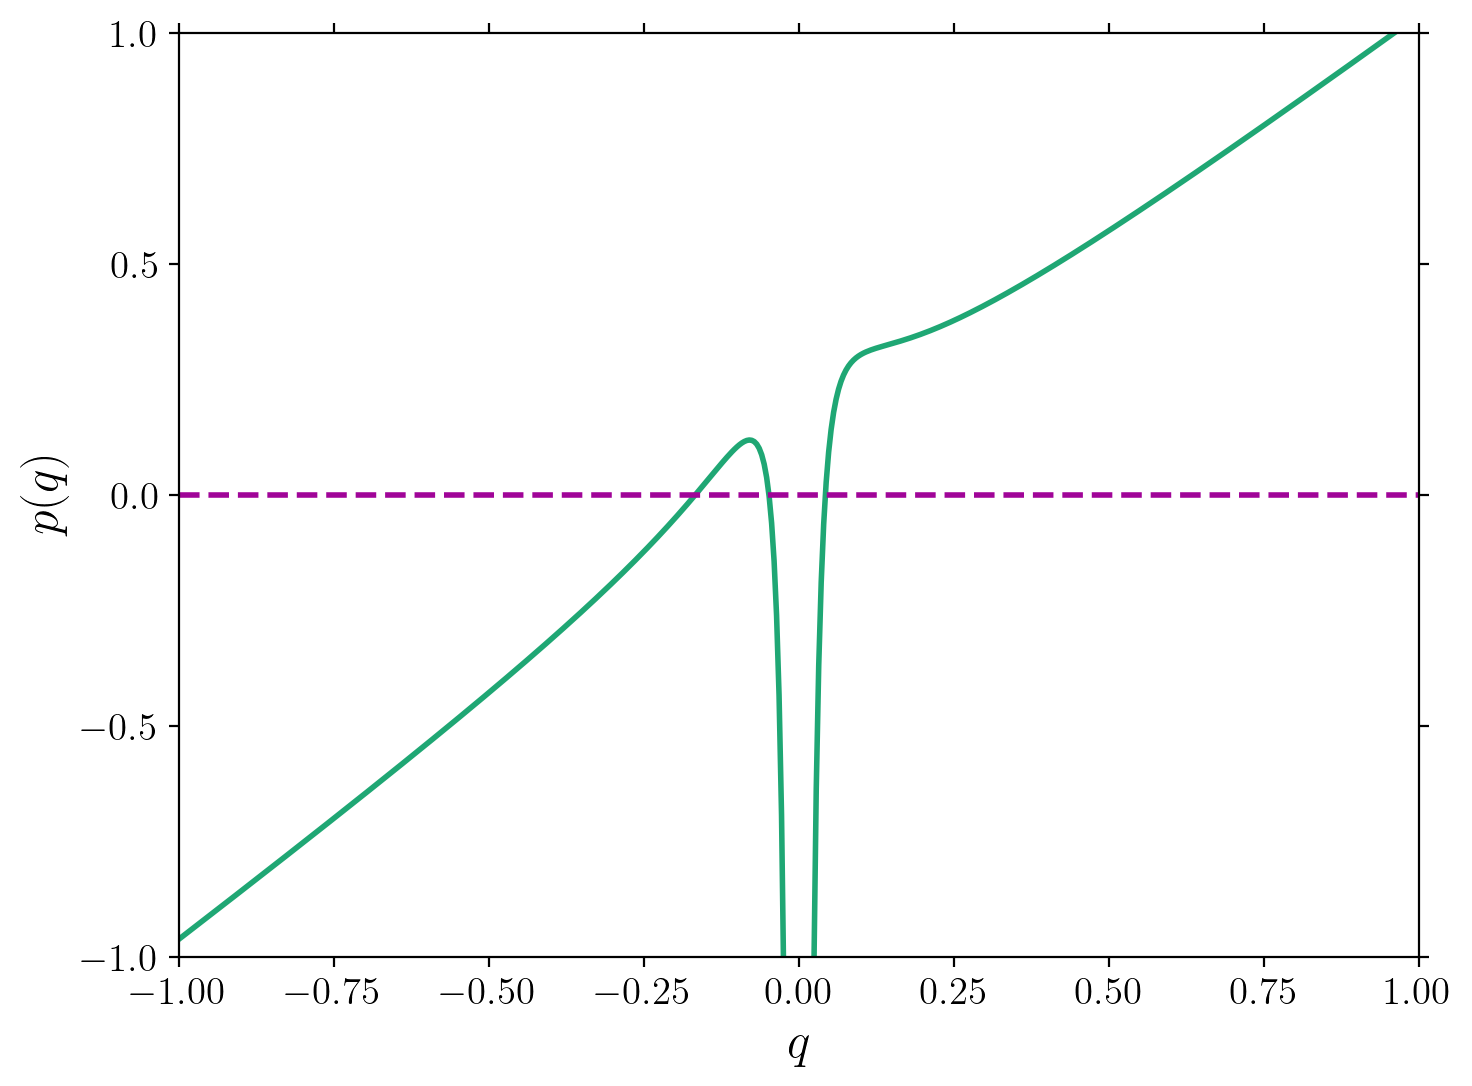

In [20]:
params["R"] = 0.96
qq = np.linspace(-1,1, num=501, endpoint=True)

fig, ax = plt.subplots()
plt.plot(qq, p(qq, **params), linewidth=2, linestyle="solid", color='xkcd:jade')
plt.plot(qq, np.zeros_like(qq), linewidth=2, linestyle="dashed", color='xkcd:barney purple')

if usetex:
    plt.xlabel("$q$", fontsize=18, color = 'k')
    plt.ylabel("$p(q)$", fontsize=18, color = 'k')
else:
    plt.xlabel("q", fontsize=18, color = 'k')
    plt.ylabel("p(q)", fontsize=18, color = 'k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=14, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=14, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=8)

plt.xlim([-1,1])
plt.ylim([-1,1])

fig.set_size_inches(8, 6)  

plt.show()

Playing with this code reveals that the dynamics bifurcates at the circulation shutdown value $R_{\mathrm{stop}} = \frac{\epsilon}{\mu}$ and at another value $R_{\mathrm{switch}}\approx 0.97$ (for the default parameter values of $\epsilon, \mu$). 

1) For $R<R_{\mathrm{stop}}$, there is a single equilibrium with $q<0$.
2) When $R=R_{\mathrm{stop}}$, we gain an additional equilibrium $q=0$.
3) For $R_{\mathrm{stop}}<R<R_{\text{switch}}$, there are three equilibria: two negative and one positive.
4) For $R>R_{\text{switch}}$ there is a single equilibrium with $q>0$.

The stability these equilibria has already been determined numerically: there is a single stable equilibrium $q$ that switches from negative to positive at $R_{\text{switch}}$. Thus, the "middle branch'' of equilibria is unstable. From our earlier discussion, an unstable shutdown equilibrium is definitely physics, which is again great news for Fowler's explanation of DO events. 

Note that different variants of the Stommel 2-box model (see Stommel 1961, Dijkstra ch.10) actually feature *bistability*, where part of the middle branch ends up being stable as well! Here, our experiments indicate we only get bistability for $R=R_{\mathrm{switch}}$. I want to emphasize how cool of a feature this is: if the model parameters are just so, the THC undergoes a hysteretic reversal! 

We can again use root-finding to get the unstable equilibria across the "gap" in $R$-values not addressed by the stable bifurcation diagram. Since $p(q)$ is not smooth at $q=0$, numerically determining its roots requires a bit of care. As long as our Newton iterations stay on one side of the real line (positive or negative), all should be well. Here we hope for the best and it turns out to work up to a minor warning! For the sake of this pedagogical presentation, such a warning shouldn't deter us. 

In [21]:
R_samples_zoomed = np.linspace(0.6, 0.98, num = R_samplesize, endpoint=True)
q0_samples_positive = np.zeros_like(R_samples, dtype=float)
q0_samples_negative = np.copy(q0_samples_positive)

l = 2e-4

for j in range(R_samplesize):
    params["R"] = R_samples_zoomed[j]
    q0_samples_positive[j] = scipy.optimize.fsolve(lambda q: p(q, **params), x0=l)[0]
    q0_samples_negative[j] = scipy.optimize.fsolve(lambda q: p(q, **params), x0=-l)[0]

/tmp/ipykernel_827654/1724299940.py:10: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  q0_samples_negative[j] = scipy.optimize.fsolve(lambda q: p(q, **params), x0=-l)[0]


Putting it all together, we have a complete sketch of the bifurcation diagram for $q$ as a function of $R$: 

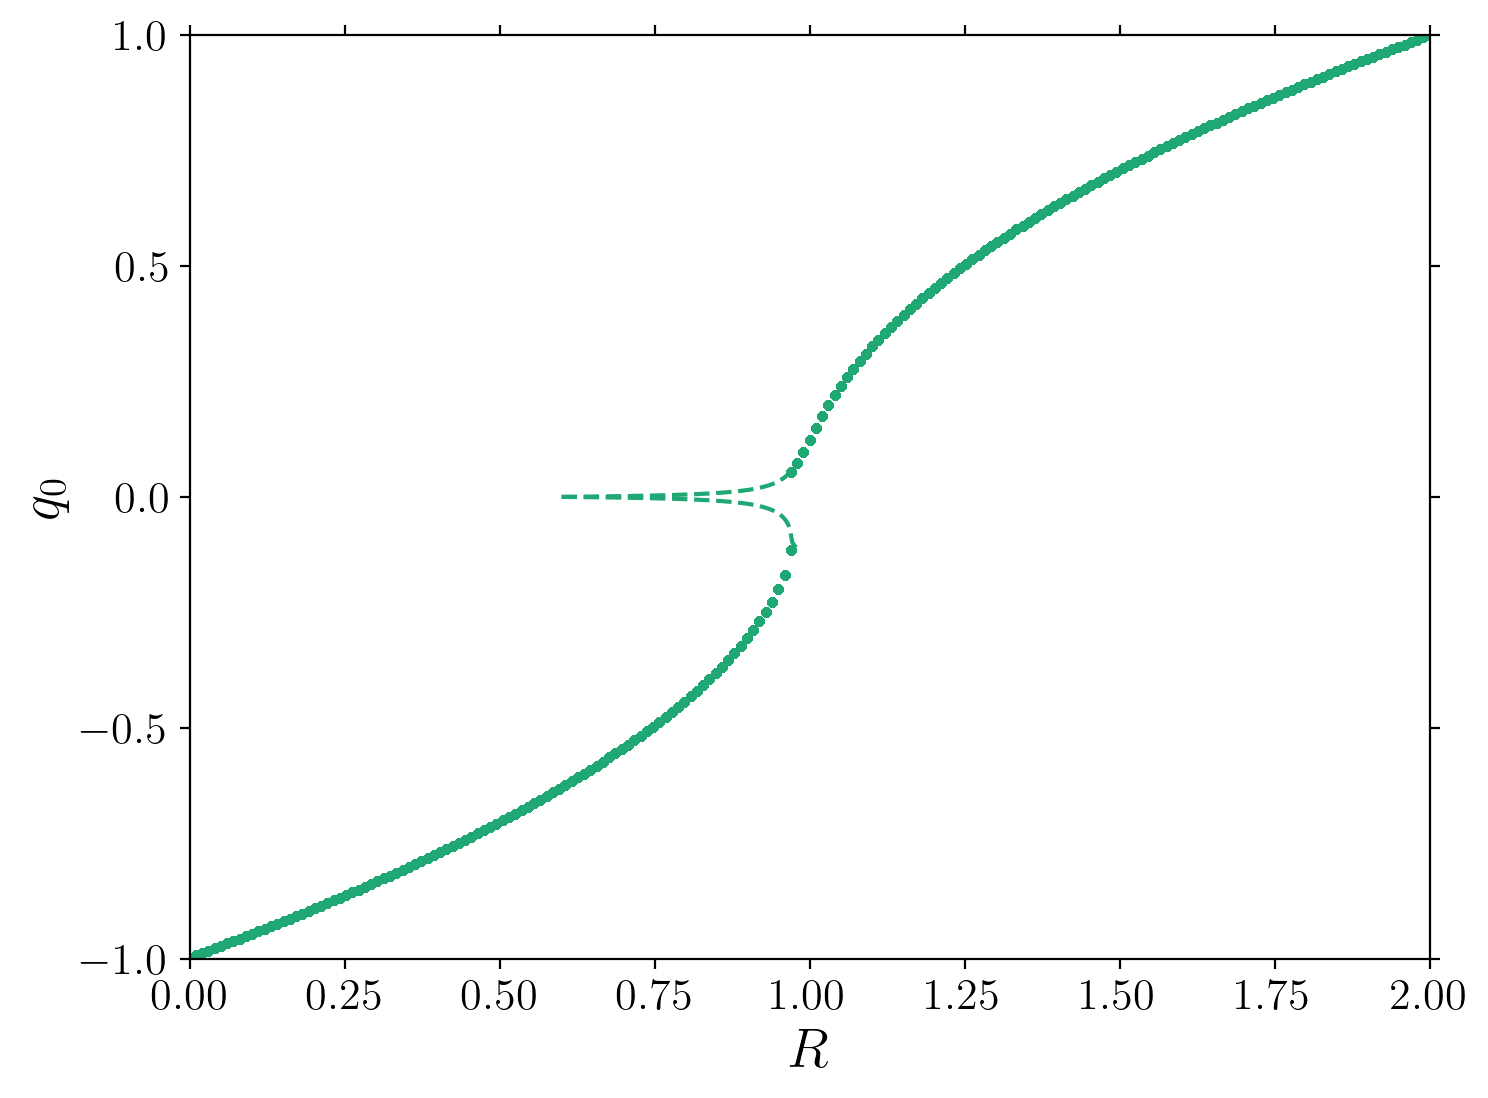

In [22]:
fig, ax = plt.subplots()
plt.plot(R_samples_zoomed, q0_samples_positive, color="xkcd:jade", linestyle="dashed")
plt.plot(R_samples_zoomed, q0_samples_negative, color="xkcd:jade", linestyle="dashed")
plt.scatter(np.ravel(np.tile(R_samples, tail_size*x0_samplesize)),np.ravel(tails), s=6, color='xkcd:jade')

if usetex:
    plt.xlabel(r"$R$", fontsize=20, color = 'k')
    plt.ylabel(r"$q_{0}$", fontsize=20, color='k')
else: 
    plt.xlabel(r"R", fontsize=20, color = 'k')
    plt.ylabel(r"q_{0}", fontsize=20, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=8)

plt.xlim([0.,2.])
plt.ylim([-1.,1.])

fig.set_size_inches(8, 6)  
plt.show()

Compare the above with figure 2.23 in Fowler. The lesson here is that the diagram is best drawn in pieces (to avoid nastiness with the absolute value) after identifying the two bifurcation values $R_{\text{stop}}$ and $R_{\text{switch}}$. 

In summary, we have used a Stommel two-box toy model to demonstrate that flow reversal is a basic feature of heat-salt engines like the THC. This lends creedence to the hypothesis that THC reversals are a possible explanation for DO events.

Of course, more physically realistic modelling and more attention to the GRIP time series is required before we can claim that we've got a realistic mechanistic phenomenology for DO events!  

One could also use this code to experiment directly with periodic freshwater forcings, say by specifying a time dependence for some important parameter like $R$. It would be interesting to see a forced simulation where we observe the transition from poleward to equatorial flow! 